In [1]:
import numpy as np
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, PILToTensor, CenterCrop, ConvertImageDtype
from skimage import io
import torch
import torch.nn as nn
from einops import rearrange, repeat
import pandas as pd
import sys
sys.path.insert(0, '../utils/')
from dataset import ChestImage64
import os
import time
import datetime

from PIL import Image

import matplotlib.pyplot as plt
import csv

from torchvision.models import vit_l_16, ViT_L_16_Weights,vit_b_16, ViT_B_16_Weights
from torch.utils.data import random_split, DataLoader, Dataset

In [2]:
csv_path = "../Data/256pxImages/train_labels_256p_paired.csv"
root_path = '../Data/256pxImages'

pairCSV = pd.read_csv(csv_path)
pairCSV['EncodedLabels'] = ''
print(pairCSV.shape)

for i in range(4, pairCSV.shape[1]-1):
    pairCSV['EncodedLabels'] = pairCSV['EncodedLabels'].astype(str) + pairCSV.iloc[:, i].astype(str) 
    if i < pairCSV.shape[1]-2:
        pairCSV['EncodedLabels'] = pairCSV['EncodedLabels'].astype(str) + "," 

pairCSV.head()

(30630, 19)


,Front Path,Lateral path,Patient,Study,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,EncodedLabels
0,Frontal\patient00002_study1_Frontal.png,Lateral\patient00002_study1_Lateral.png,patient00002,study1,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
1,Frontal\patient00004_study1_Frontal.png,Lateral\patient00004_study1_Lateral.png,patient00004,study1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
2,Frontal\patient00005_study1_Frontal.png,Lateral\patient00005_study1_Lateral.png,patient00005,study1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"0,0,0,0,0,0,0,0,0,0,0,0,1,0"
3,Frontal\patient00009_study1_Frontal.png,Lateral\patient00009_study1_Lateral.png,patient00009,study1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"1,1,0,0,0,0,0,0,0,0,0,0,0,0"
4,Frontal\patient00010_study1_Frontal.png,Lateral\patient00010_study1_Lateral.png,patient00010,study1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"


In [3]:
# test image loading
front_file = pairCSV.iloc[0, 0]
lat_file= pairCSV.iloc[0, 1]
label_test = pairCSV['EncodedLabels'].iloc[0]

test_path_front = os.path.join(root_path, front_file)
test_path_lat = os.path.join(root_path, lat_file)

label_test = [int(x) for x in label_test.split(",")]

print("label_test: ", label_test)

image_front = io.imread(test_path_front)
print(type(image_front))
image_front = torch.tensor(image_front)
print(image_front.size())

image_lat = io.imread(test_path_lat)
print(type(image_lat))
image_lat = torch.tensor(image_lat)
print(image_lat.size())

label_test:  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
<class 'numpy.ndarray'>
torch.Size([256, 256])
<class 'numpy.ndarray'>
torch.Size([256, 256])


In [4]:
# load up the paired dataset
class PairedDataset(Dataset):
    def __init__(self, df, root_dir, label_col, transform = None):
        self.df = df
        self.root_dir = root_dir
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        # get the filename of the image
        file_front = self.df.iloc[index, 0]
        file_lat = self.df.iloc[index, 1]
        label = self.df[self.label_col].iloc[index]

        if type(label) == str:
            label = [int(x) for x in label.split(",")]

        # load the image from disk
        front_path = os.path.join(self.root_dir, file_front)
        lat_path = os.path.join(self.root_dir, file_lat)

        img_front = Image.open(front_path).convert('RGB')
        img_lat = Image.open(lat_path).convert('RGB')

        label = torch.tensor(label)
        label = label.float()

        img_front = self.transform(img_front)
        #img_front = torch.tensor(img_front)
        #img_front = img_front.resize_((224, 224))
        #img_front = repeat(img_front, "h w -> (repeat h) w", repeat = 3)
        img_front = rearrange(img_front, "c h w -> 1 c h w")
        #img_front = img_front.float()

        img_lat = self.transform(img_lat)
        #img_lat = img_lat.resize_((224, 224))
        #img_lat = repeat(img_lat, "h w -> (repeat h) w", repeat = 3)
        img_lat = rearrange(img_lat, "c h w -> 1 c h w")
        #img_lat = img_lat.float()

        img_pair=torch.cat((img_front,img_lat),0)


        # if self.transform:
            # label = self.transform(label)
            # img = self.transform(img)

        # return the image and its filename
        return img_pair, label

In [5]:
class AllAttentionVIT(nn.Module):
    def __init__(self,weights_frontal,weights_lateral,code_size,num_classes,bottleneck=1024,drop_rate=0.1):
        
        super(AllAttentionVIT,self).__init__()

        #Initialize the model
        self.transformer_enc_frontal = vit_b_16(weights = weights_frontal)
        self.transformer_enc_frontal.heads = nn.Sequential(nn.Linear(768, code_size))
        self.transformer_enc_lateral = vit_b_16(weights = weights_lateral)
        self.transformer_enc_lateral.heads = nn.Sequential(nn.Linear(768, code_size))

        self.dropout = nn.Dropout(p = drop_rate)
        self.ff = nn.Linear(code_size*2,num_classes)

    #Expect two images with the same class.
    def forward(self,x):

        #Split up paired images
        x_f=x[:, 0, :, :, :]
        x_l=x[:, 1, :, :, :]
        
        #Encode front and lateral embeddings
        x_f = self.transformer_enc_frontal(x_f)
        x_l = self.transformer_enc_frontal(x_l)

        #Concat embeddings. May want to experiment with convolutions.
        x = torch.cat((x_f,x_l),1)

        #Map concatenated embeddings onto the classes
        x = self.dropout(x)
        x = self.ff(x)

        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
def transform_val(input):
    if input < 0:
        x = 0.0
    else:
        x = 1.0
    return x    

In [8]:
def train_model(pairDataset,config, benchmark=0.33):
    # now let's train this thing. 
    
    #batchsize = 2
    #epochs = 1
    #learning_rate = 0.003
    
    learning_rate=config["lr"]
    batchsize=config["batch_size"]
    #dropout=config["d1"]
    epochs=config["epochs"]
    
    # split into test train validate
    train_size = int(0.7 * len(pairDataset))
    val_size = int(0.1 * len(pairDataset))
    test_size = int(0.2 * len(pairDataset))


    train_dataset, val_dataset, test_dataset = random_split(pairDataset, [train_size, val_size, test_size])
    
    #default_transform = ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms
    #pairDataset = PairedDataset(pairCSV, root_dir=root_path, label_col="EncodedLabels", transform=default_transform)
    
    target_accumulation=32
    accum_iter = target_accumulation/batchsize  
    #print(accum_iter)
    
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
    test_loader = DataLoader(test_dataset,batch_size=batchsize, shuffle=True)
    
    features, labels = next(iter(train_loader))
    
    testWeights=ViT_B_16_Weights.DEFAULT
    testModel = AllAttentionVIT(testWeights,testWeights,768,14)

    criterion = nn.BCEWithLogitsLoss()

    # make sure the model is running on the GPU if its available
    testModel.to(device)

    # Observe that all parameters are being optimized
    params_to_update = testModel.parameters()
    optimizer = torch.optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)


    # optimizer = optim.Adam(model500k.parameters(), lr=learning_rate)

    # start a clock 
    print("Training Starting.")
    start_time = time.time()

    # create empty arrays to hold the loss results
    training_losses = []
    validation_losses = []
    for epoch in range(epochs):
        phase = 'train'
        # set the model to training mode
        testModel.train()
        running_loss = 0.0

    # zero the parameter gradients at the very beginning
        optimizer.zero_grad()


        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # ugh. This is gross. I should have done this step at the beginning for all of the datasets. 
            # zero the parameter gradients
            optimizer.zero_grad()
            # print("Here's the size of the inputs: ", inputs.size())
            # with torch.set_grad_enabled(phase == 'train'):
                # run the training data through the model
            outputs = testModel(inputs)

            #calculate the loss of the model
            loss = criterion(outputs, labels)

            #Gradient accumulation
            loss = loss / accum_iter
            loss.backward()

            running_loss += loss.item()

            # weights update for each gradient accumulation
            if ((i + 1) % accum_iter == 0) or (i + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

                if ((i + 1) / accum_iter) % 50 == 0:    # record loss and test validation set every 50 gradient accumulations
                    testModel.eval()
                    v_running_loss = 0.0
                    for v, data in enumerate(val_loader):
                        inputs, labels = data[0].to(device), data[1].to(device)
                        v_outputs = testModel(inputs)
                        v_loss = criterion(v_outputs, labels)
                        v_running_loss += v_loss.item()

                    print("Time: ", datetime.datetime.now().strftime("%H:%M:%S"), "\tepoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "Validation loss ", v_running_loss)
                    validation_losses.append(v_running_loss)
                    training_losses.append(running_loss)
                    running_loss = 0.0


    end_time = time.time()
    train_time = end_time - start_time
    print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
    print('Finished Training')
    
    #model_name= "vitb_model_e" + str(epochs) + f"_drop{dropout:.0e}" + f"_lr{learning_rate:.0e}" + "_bs "+ str(batch_size)
    model_name= "vitb_multimodal_e" + str(epochs) + f"_lr{learning_rate:.0e}" + "_bs "+ str(batch_size)
    model_filepath="../Logging/" + model_name + ".pth"

    figure_path="../Logging/" + model_name + ".png"

    print(model_filepath)

    torch.save(testModel.state_dict(), model_filepath)

    fig, axs = plt.subplots()
    axs.plot(training_losses)
    axs.plot(validation_losses)
    axs.set_title("Losses")
    axs.set_xlabel("Mini Batchs")
    axs.set_ylabel("Loss")

    fig.suptitle(model_name)
    plt.savefig(figure_path, dpi=300)
    
    testModel.eval()
    total = 0.0
    v_corc_arr = np.zeros((1,14))
    v_acc_string = "_"

    for v, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = testModel(vinputs)
        for i in range(voutputs.shape[0]):
            total += 1
            for j in range(voutputs.shape[1]):
                if transform_val(voutputs[i,j].cpu().detach().numpy()) == vlabels[i,j].cpu().detach().numpy():
                    v_corc_arr[0,j] = v_corc_arr[0,j] + 1
    
    v_corc_arr=v_corc_arr/total

    for acc in range(14):
        v_acc_string = v_acc_string + "/" + str(v_corc_arr[0,acc])
    
    #return running_loss, v_running_loss, accuracy, epoch
    return running_loss, v_running_loss, v_acc_string, epoch
    
    
    #return running_loss, v_running_loss, epoch


In [9]:
testtransform = Compose([
    PILToTensor(),
    CenterCrop((224,224)),
    ConvertImageDtype(torch.float32),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
pairDataset = PairedDataset(pairCSV, root_dir=root_path, label_col="EncodedLabels", transform=testtransform)

print(type(pairDataset))

# split into test train validate
#train_size = int(0.7 * len(pairDataset))
#val_size = int(0.1 * len(pairDataset))
#test_size = int(0.2 * len(pairDataset))


#train_dataset, val_dataset, test_dataset = random_split(pairDataset, [train_size, val_size, test_size])

#print("Train Length: ", len(train_dataset))
#print("Validation Length: ", len(val_dataset))
#print("Test Length: ", len(test_dataset))

<class '__main__.PairedDataset'>


{'epochs': 1, 'lr': 0.001, 'batch_size': 8}
Train Start. Iteration:  1
Training Starting.
Time:  20:04:49 	epoch:  1 batch:  200 Training loss:  33.203687846660614 Validation loss  232.78146201372147
Time:  20:05:55 	epoch:  1 batch:  400 Training loss:  29.496306739747524 Validation loss  220.1056507229805
Time:  20:07:01 	epoch:  1 batch:  600 Training loss:  28.22615211457014 Validation loss  216.67375019192696
Time:  20:08:07 	epoch:  1 batch:  800 Training loss:  27.41973427683115 Validation loss  215.36753037571907
Time:  20:09:14 	epoch:  1 batch:  1000 Training loss:  27.57063653320074 Validation loss  213.31008797883987
Time:  20:10:19 	epoch:  1 batch:  1200 Training loss:  27.51187215000391 Validation loss  210.3160618543625
Time:  20:11:25 	epoch:  1 batch:  1400 Training loss:  26.990560792386532 Validation loss  208.71591839194298
Time:  20:12:31 	epoch:  1 batch:  1600 Training loss:  26.38324051350355 Validation loss  206.27144768834114
Time:  20:13:37 	epoch:  1 batch:

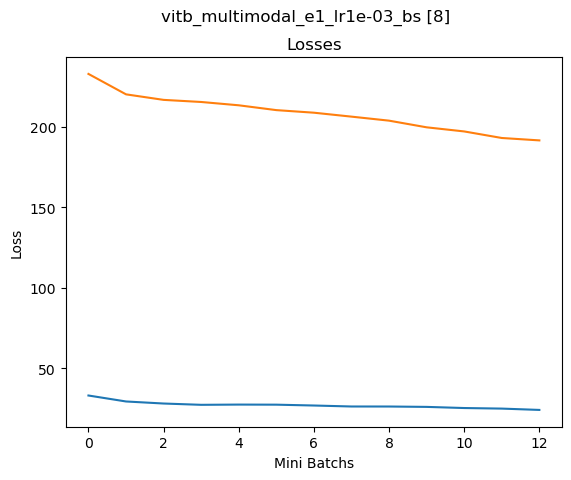

In [10]:
result_list = []

#Grid search parameters
batch_size=[8]
learn_rate=[0.001]
epochs=[1]


it=0
#for d in dropout:
for e in epochs:
    for bs in batch_size:
        for lr in learn_rate:

            it +=1 
            #config = {"d1": d,"lr": lr,"batch_size": bs}
            config = {"epochs": e, "lr": lr, "batch_size": bs}
            #config = {"lr": lr,"batch_size": bs}

            print(config)
            print("Train Start. Iteration: ",it)
            t_loss,v_loss, v_acc_str, end_Ep=train_model(pairDataset,config)
            #t_loss,v_loss, acc, end_Ep=train_model(train_dataset, val_dataset,config)

            list_row= str(bs) + "," + str(lr) + "," + str(t_loss) + "," + str(v_loss) + "," + str(end_Ep) + "," + v_acc_str
            #list_row= str(bs) + "," + str(lr) + "," + str(t_loss) + "," + str(v_loss) + "," + str(end_Ep), + "," + str(acc)

            t_list=[list_row]  
            result_list.append(t_list)


with open('opt_results_multimodal.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerow(result_list)